In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

# 데이터 확인

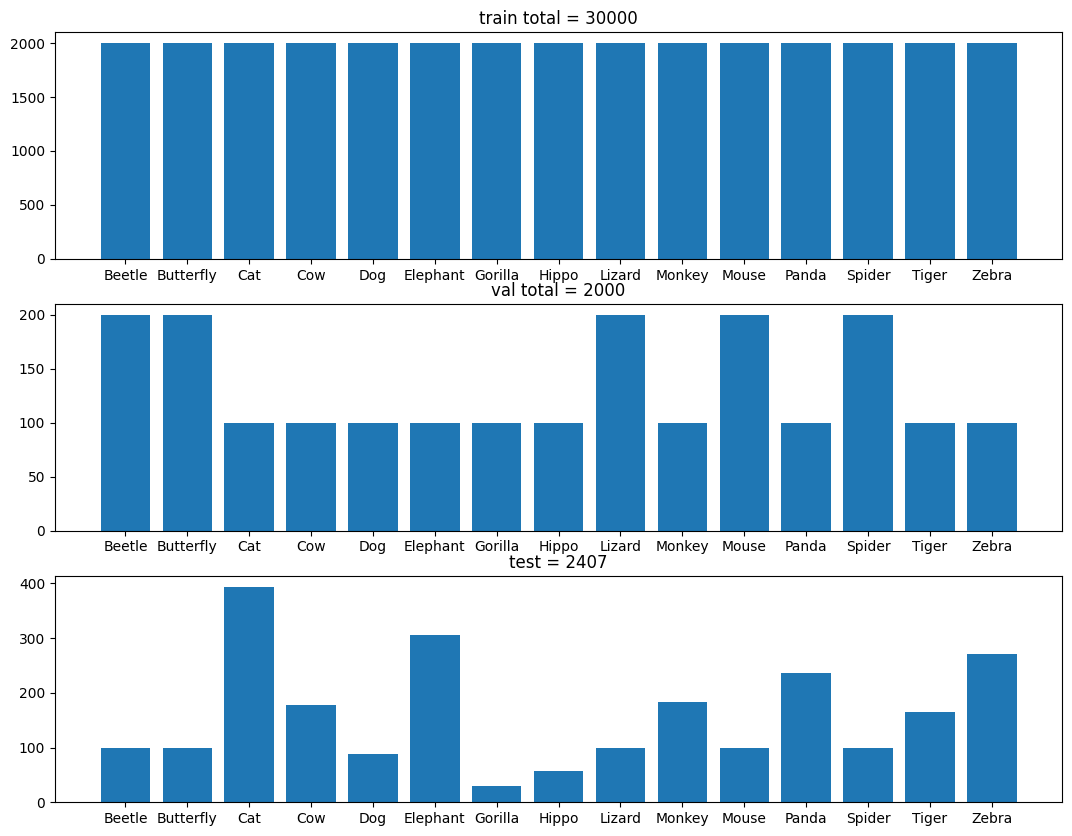

In [2]:
train_data_dir = '/home/hts/A_project/hts_pytorch/data/animal_image_data/Training Data/Training Data/'
val_data_dir = '/home/hts/A_project/hts_pytorch/data/animal_image_data/Validation Data/Validation Data/'
test_data_dir = '/home/hts/A_project/hts_pytorch/data/animal_image_data/Testing Data/Testing Data/'

train_class_name = sorted(os.listdir(train_data_dir))
val_class_name = sorted(os.listdir(val_data_dir))
test_class_name = sorted(os.listdir(test_data_dir))

trian_class_name_number = [len(os.listdir(train_data_dir + train_class_name[i])) for i in range(len(train_class_name))]
val_class_name_number = [len(os.listdir(val_data_dir + val_class_name[i])) for i in range(len(val_class_name))]
test_class_name_number = [len(os.listdir(test_data_dir + test_class_name[i])) for i in range(len(test_class_name))]

plt.figure(figsize=(13,10))
plt.subplot(311)
plt.bar(train_class_name, trian_class_name_number)
plt.title(f"train total = {sum(trian_class_name_number)}")

plt.subplot(312)
plt.bar(val_class_name, val_class_name_number)
plt.title(f"val total = {sum(val_class_name_number)}")

plt.subplot(313)
plt.bar(test_class_name, test_class_name_number)
plt.title(f"test = {sum(test_class_name_number)}")

plt.show()

# 데이터셋 제작

In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
def build_dataloader(T_batch_size=200, V_batch_size = 128):
    dataloader = {}

    train_set = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transformer)
    val_set = torchvision.datasets.ImageFolder(root=val_data_dir, transform=transformer)

    dataloader['train']= DataLoader(dataset=train_set, batch_size=T_batch_size, num_workers=4, shuffle=True)
    dataloader['val'] = DataLoader(dataset=val_set,batch_size=V_batch_size,num_workers=4,shuffle=False)

    return dataloader

# 모델 제작

In [5]:
def resnet_model():
    resnet = models.resnet50(pretrained=True)

    num_fitturs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_fitturs, 15)
    return resnet

# 학습 함수

In [6]:
def train_one_epoch(dataloaders, model, optimizer, device):
    total_loss = {}

    for phase in ['train', 'val']:
        running_loss = 0.0

        if phase =='train':
            model.train()
        elif phase == 'val':
            model.eval()
        with tqdm(dataloaders[phase], unit='batch', desc=f"Epoch {phase}") as tepoch:
            for batch in tepoch:

                image = batch[0].to(device)
                target = batch[1].to(device)

                with torch.set_grad_enabled(phase=='train'):
                    predict = model(image)

                    loss = F.cross_entropy(predict, target, reduction = 'mean')

                    if phase =='train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item()
                tepoch.set_postfix(loss =running_loss / (tepoch.n +1))

        total_loss[phase] = running_loss/len(dataloaders[phase])
            

    return total_loss

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
dataloaders = build_dataloader()
model = resnet_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
num_epoch = 300
train_loss = []
val_loss = []
best_loss = 100

for epoch in range(num_epoch):
    loss = train_one_epoch(dataloaders=dataloaders, model=model, optimizer=optimizer, device=device)
    train_loss.append(loss['train'])
    val_loss.append(loss['val'])
    print(f"{epoch+1}/{num_epoch}--train_loss : {loss['train']}, val_loss : {loss['val']}")

    if(loss['val']<best_loss):
        best_loss = loss['  val']
        best_model = copy.deepcopy(model.state_dict())
        os.makedirs('./trained_model/', exist_ok=True)
        torch.save(best_model, os.path.join('./trained_model/','bestmodel.pt'),_use_new_zipfile_serialization=False)

print(f'bestmodel : {best_loss}')

Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.41batch/s, loss=0.127]


1/300--train_loss : 0.25992653988301756, val_loss : 0.12732440535910428


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.28batch/s, loss=0.117]


2/300--train_loss : 0.031262055452292166, val_loss : 0.11651379225077108


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.29batch/s, loss=0.141]


3/300--train_loss : 0.013972703289085378, val_loss : 0.14109168003778905


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.38batch/s, loss=0.139]


4/300--train_loss : 0.008719997146787744, val_loss : 0.13893358455970883


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.36batch/s, loss=0.147]


5/300--train_loss : 0.0167402215480494, val_loss : 0.14655335259158164


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.29batch/s, loss=0.147]


6/300--train_loss : 0.022116883636141817, val_loss : 0.14665540406713262


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.41batch/s, loss=0.163]


7/300--train_loss : 0.01562333329891165, val_loss : 0.16289269938715734


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.38batch/s, loss=0.176]


8/300--train_loss : 0.014439244462409987, val_loss : 0.17555605981033295


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.46batch/s, loss=0.191]


9/300--train_loss : 0.013708082724673052, val_loss : 0.19113345199730247


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.34batch/s, loss=0.144]


10/300--train_loss : 0.009134486234979705, val_loss : 0.14375577785540372


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.40batch/s, loss=0.151]


11/300--train_loss : 0.006270604220723423, val_loss : 0.15130525988934096


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.39batch/s, loss=0.139]


12/300--train_loss : 0.002390590014595849, val_loss : 0.13931369845522568


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.33batch/s, loss=0.132]


13/300--train_loss : 0.0009885993123558972, val_loss : 0.13209484406979755


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.25batch/s, loss=0.129]


14/300--train_loss : 0.000710659339626242, val_loss : 0.12892380745324772


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.38batch/s, loss=0.134]


15/300--train_loss : 0.0006473465486730372, val_loss : 0.13361247926513897


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.29batch/s, loss=0.133]


16/300--train_loss : 0.0005374032737745438, val_loss : 0.13297996886103647


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.40batch/s, loss=0.129]


17/300--train_loss : 0.0005246372592955595, val_loss : 0.12937939297262346


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.28batch/s, loss=0.129]


18/300--train_loss : 0.0004911316853394964, val_loss : 0.12910456829558825


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.23batch/s, loss=0.133]


19/300--train_loss : 0.0004797048146671538, val_loss : 0.13291878259769874


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.30batch/s, loss=0.134]


20/300--train_loss : 0.0004817451085182256, val_loss : 0.13379564182832837


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.26batch/s, loss=0.129]


21/300--train_loss : 0.0004596152423133996, val_loss : 0.12929877440910786


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.36batch/s, loss=0.133]


22/300--train_loss : 0.0004496810335088715, val_loss : 0.13334913804465032


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.31batch/s, loss=0.131]


23/300--train_loss : 0.0004317790183025257, val_loss : 0.13092494902593899


Epoch val: 100%|██████████| 16/16 [00:03<00:00,  5.30batch/s, loss=0.13] 


24/300--train_loss : 0.00042193468751065664, val_loss : 0.1298164567197091


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.36batch/s, loss=0.135]


25/300--train_loss : 0.00041233857062858686, val_loss : 0.13510843757831026


Epoch val: 100%|██████████| 16/16 [00:02<00:00,  5.36batch/s, loss=0.131]


26/300--train_loss : 0.0003975661677638224, val_loss : 0.13056873376990552


Epoch train:  35%|███▍      | 52/150 [00:44<01:23,  1.17batch/s, loss=0.000369]


KeyboardInterrupt: 

In [12]:
test_model = resnet_model()
test_model.load_state_dict(torch.load('./trained_model/bestmodel.pt'))
test_model.eval()

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_set = torchvision.datasets.ImageFolder(root=test_data_dir, transform=test_transformer)
test_dataloader = DataLoader(dataset=test_set,batch_size=2407,num_workers=4,shuffle=False)

total_score = 0
test_count = 0

for batch in test_dataloader:
    image = batch[0]
    target = batch[1]

    with torch.set_grad_enabled(False):
        output = test_model(image)
        output = torch.argmax(output, dim=1)

        for i,j in zip(output, target):
            test_count +=1
            if i==j:
                total_score +=1

print(total_score/test_count)

0.9426672206065642
